# Navier-Stokes Equation
## A 2+1 Dimensional Numerical Experiment of FNOs

This notebook walks through the Fourier Neural Operator for a 2D problem such as the Navier-Stokes discussed in Section 5.3 in the paper [Fourier Neural Operator for
Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf) which uses a recurrent structure to propagates in time.

In [1]:
from typing import Any, Callable, Generic, NamedTuple, Optional, Tuple, TypeVar

import yaml
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer

from torch.nn.functional import mse_loss
import torch

from neuralop import count_params
from neuralop.datasets import load_navier_stokes_temporal_pt
from neuralop.layers import SpectralConv2d
from neuralop.models import FNO2d
from neuralop.training import LpLoss

torch.manual_seed(0)
np.random.seed(0)

In [2]:
#################################################
# Utilities
#################################################
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [3]:
################################################################
# fourier layer
################################################################
print(
"""
The overall network. It contains 4 layers of the Fourier layer.
1. Lift the input to the desire channel dimension by self.fc0 .
2. 4 layers of the integral operators u' = (W + K)(u).
    W defined by self.w; K defined by self.conv .
3. Project from the channel space to the output space by self.fc1 and self.fc2 .

input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
input shape: (batchsize, x=64, y=64, c=12)
output: the solution of the next timestep
output shape: (batchsize, x=64, y=64, c=1)
"""
)


The overall network. It contains 4 layers of the Fourier layer.
1. Lift the input to the desire channel dimension by self.fc0 .
2. 4 layers of the integral operators u' = (W + K)(u).
    W defined by self.w; K defined by self.conv .
3. Project from the channel space to the output space by self.fc1 and self.fc2 .

input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
input shape: (batchsize, x=64, y=64, c=12)
output: the solution of the next timestep
output shape: (batchsize, x=64, y=64, c=1)



In [4]:
class Config(NamedTuple):
    train_path: str
    test_path: str
    n_train: int
    n_test: int
    train_batch_size: int
    test_batch_size: int
    learning_rate: float
    epochs: int
    iterations: int
    modes: int
    width: int
    subsampling_rate: int
    s: int
    history_length: int
    future_duration: int
    step: int
        
    @staticmethod
    def from_yaml(config_path: str):
        with open(config_path, 'r') as f:
            cfg = yaml.load(f)

        config = Config(
            train_path=cfg['train_path'],
            test_path=cfg['test_path'],
            n_train=cfg['n_train'],
            n_test=cfg['n_test'],
            train_batch_size=cfg['train_batch_size'],
            test_batch_size=cfg['test_batch_size'],
            learning_rate=cfg['learning_rate'],
            epochs=cfg['epochs'],
            iterations=cfg['iterations'],
            modes=cfg['modes'],
            width=cfg['width'],
            subsampling_rate=cfg['subsampling_rate'],
            s=cfg['s'],
            history_length=cfg['history_length'],
            future_duration=cfg['future_duration'],
            step=cfg['step'],
        )        
        return config


config = Config.from_yaml('fourier_2d_time_V1e-3.yaml')

In [5]:
################################################################
# load data and data normalization
################################################################

train_loader, test_loader, output_encoder = load_navier_stokes_temporal_pt(
    config.train_path, # Currently, the same path is used for both training and testing data.
    config.n_train,
    config.n_test,
    config.history_length,
    config.future_duration,
    config.train_batch_size,
    config.test_batch_size,
)

UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [10, 64, 64].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [40, 64, 64].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05


In [6]:
model = FNO2d(
    config.modes,  # modes_width
    config.modes,  # modes_height
    config.width,  # width of all hidden layers
    # input channels are 12: the solution of the previous 10 timesteps + 2 location encodings
    # i.e: (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
    in_channels=2 + config.history_length,
    out_channels=1,  # output channel is 1: u(t, x, y)
    n_layers=4,
    # domain_padding=8,
    domain_padding=None,
    # domain_padding_mode='one-sided',
    use_mlp=True,
).cuda()
print(f"Model parameter count: {count_params(model):,d}")

Model parameter count: 239,773


In [7]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.iterations
)
lp_loss = LpLoss()  # By default, does not do size averaging
output_encoder.cuda()

header_strings = (
    'Epoch',
    'Duration',
    'Training L2 (step)',
    'Training L2 (full)',
    'Testing L2 (step)',
    'Testing L2 (full)',
)
HEADER = ' | '.join(header_strings)
for ep in range(config.epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for train_data in train_loader:
        xx = train_data['x'].to(device)
        yy = train_data['y'].to(device)
        loss = 0

        # For each time step
        for t in range(0, config.future_duration, config.step):
            # We want the operator to learn the next S time steps:
            y = yy[:, t:t + config.step, ...]
            # use recurrent structure to propagate in time:
            im = model(xx)
            loss += lp_loss(
                im.reshape(config.train_batch_size, -1),
                y.reshape(config.train_batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), 1)

            # Advance the recurrent input by one time step; i.e:
            # [t_n, ..., t_{n+m}] --> [t_{n+s}, ..., t_{n+s+m}]
            # for starting time N, future duraiton M, and time step S
            xx = torch.cat((
                xx[..., config.step:-2, :, :],  # [t_{n+s}, ..., t_{n+m}]
                im,                             # [t_{n+m+1}, ..., t_{n+m+s}]
                xx[..., -2:, :, :]              # positional encoding
            ), dim=1)

        # Compare the full, operator-predicted future with the ground truth.
        # This is not used in training, but surfaces how well 
        # the operator has done overall in this epoch.
        train_l2_step += loss.item()
        l2_full = lp_loss(
            pred.reshape(config.train_batch_size, -1), 
            yy.reshape(config.train_batch_size, -1))
        train_l2_full += l2_full.item()

        # Backprop based only on the loss for each step-by-step in time.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    model.eval()
    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        for test_data in test_loader:
            xx = test_data['x'].to(device)
            yy = test_data['y'].to(device)
            loss = 0

            for t in range(0, config.future_duration, config.step):
                y = yy[:, t:t + config.step, ...]
                im = model(xx)
                loss += lp_loss(
                    im.reshape(config.test_batch_size, -1), 
                    y.reshape(config.test_batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), 1)

                xx = torch.cat((
                    xx[..., config.step:-2, :, :],  # [t_{n+s}, ..., t_{n+m}]
                    im,                             # [t_{n+m+1}, ..., t_{n+m+s}]
                    xx[..., -2:, :, :]              # positional encoding
                ), dim=1)

            test_l2_step += loss.item()
            test_l2_full += lp_loss(
                pred.reshape(config.test_batch_size, -1), 
                yy.reshape(config.test_batch_size, -1)).item()

    t2 = default_timer()
    train_l2_step_normed = train_l2_step / config.n_train / (config.future_duration / config.step)
    train_l2_full_normed = train_l2_full / config.n_train
    test_l2_step_normed = test_l2_step / config.n_test / (config.future_duration / config.step)
    test_l2_full_normed = test_l2_full / config.n_test
    if ep % 20 == 0:
        print(HEADER)
    row = ' | '.join(
        [f'{ep:{len(header_strings[0])}d}', f'{t2 - t1:{len(header_strings[1])}.3f}'] + 
        [f'{x:{len(s)}.6f}' for s, x
         in zip(header_strings[2:], (train_l2_step_normed,
                                     train_l2_full_normed,
                                     test_l2_step_normed,
                                     test_l2_full_normed))])
    print(row)

Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
    0 |   24.982 |           0.762236 |           0.782359 |          0.574685 |          0.595094
    1 |   24.576 |           0.548714 |           0.577207 |          0.544866 |          0.573732
    2 |   24.670 |           0.444411 |           0.469518 |          0.312992 |          0.316448
    3 |   24.562 |           0.273351 |           0.278741 |          0.269749 |          0.273583
    4 |   25.122 |           0.233467 |           0.237089 |          0.229275 |          0.232638
    5 |   24.522 |           0.202676 |           0.206182 |          0.214875 |          0.217973
    6 |   24.543 |           0.187083 |           0.191198 |          0.199868 |          0.203328
    7 |   24.664 |           0.169259 |           0.173267 |          0.173849 |          0.176963
    8 |   25.217 |           0.156593 |           0.160627 |          0.173517 |          0.176261
    9 |   

   79 |   24.905 |           0.043584 |           0.044592 |          0.085809 |          0.086092
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
   80 |   24.767 |           0.044749 |           0.045936 |          0.079191 |          0.079154
   81 |   24.785 |           0.040544 |           0.041232 |          0.083556 |          0.083741
   82 |   25.315 |           0.040620 |           0.041328 |          0.080043 |          0.080154
   83 |   24.903 |           0.038051 |           0.038548 |          0.078511 |          0.078518
   84 |   25.116 |           0.038279 |           0.038855 |          0.079306 |          0.079325
   85 |   24.923 |           0.042929 |           0.043969 |          0.082549 |          0.082592
   86 |   25.000 |           0.040212 |           0.040965 |          0.073518 |          0.073684
   87 |   24.601 |           0.040480 |           0.041347 |          0.089645 |          0.090271
   88 |   

  158 |   25.043 |           0.029269 |           0.029921 |          0.072263 |          0.072183
  159 |   24.808 |           0.029382 |           0.030124 |          0.078726 |          0.078653
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  160 |   25.001 |           0.031251 |           0.032098 |          0.079410 |          0.079304
  161 |   25.007 |           0.031571 |           0.032444 |          0.079395 |          0.079339
  162 |   25.004 |           0.034260 |           0.035528 |          0.082486 |          0.082667
  163 |   24.789 |           0.029887 |           0.030634 |          0.065295 |          0.065378
  164 |   24.949 |           0.030285 |           0.031092 |          0.075415 |          0.075393
  165 |   24.966 |           0.029254 |           0.029928 |          0.078577 |          0.078541
  166 |   24.891 |           0.027450 |           0.027963 |          0.072776 |          0.072681
  167 |   

  237 |   24.913 |           0.022235 |           0.022607 |          0.074191 |          0.074013
  238 |   25.476 |           0.023275 |           0.023734 |          0.067933 |          0.067817
  239 |   24.877 |           0.022648 |           0.023068 |          0.068980 |          0.068895
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  240 |   24.916 |           0.022225 |           0.022579 |          0.072145 |          0.072017
  241 |   25.271 |           0.021872 |           0.022217 |          0.073069 |          0.073007
  242 |   24.934 |           0.023060 |           0.023528 |          0.071716 |          0.071563
  243 |   24.818 |           0.023535 |           0.024064 |          0.074647 |          0.074571
  244 |   25.208 |           0.022744 |           0.023178 |          0.070709 |          0.070642
  245 |   25.373 |           0.021126 |           0.021425 |          0.073093 |          0.073046
  246 |   

  316 |   24.703 |           0.018996 |           0.019279 |          0.073789 |          0.073722
  317 |   25.021 |           0.019370 |           0.019716 |          0.069802 |          0.069673
  318 |   24.725 |           0.020452 |           0.020915 |          0.069223 |          0.069073
  319 |   24.848 |           0.018318 |           0.018572 |          0.070996 |          0.070948
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  320 |   24.677 |           0.018552 |           0.018823 |          0.071040 |          0.070932
  321 |   25.355 |           0.019127 |           0.019460 |          0.075114 |          0.075222
  322 |   24.834 |           0.018236 |           0.018492 |          0.070084 |          0.070014
  323 |   25.049 |           0.018610 |           0.018900 |          0.070810 |          0.070812
  324 |   24.966 |           0.018137 |           0.018380 |          0.072493 |          0.072438
  325 |   

  395 |   25.073 |           0.016137 |           0.016349 |          0.072278 |          0.072208
  396 |   24.782 |           0.016320 |           0.016538 |          0.070681 |          0.070597
  397 |   24.820 |           0.016238 |           0.016455 |          0.069653 |          0.069559
  398 |   25.162 |           0.016095 |           0.016309 |          0.071095 |          0.070994
  399 |   24.725 |           0.016153 |           0.016367 |          0.070274 |          0.070193
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  400 |   24.872 |           0.016161 |           0.016378 |          0.069275 |          0.069194
  401 |   25.171 |           0.016101 |           0.016317 |          0.070635 |          0.070565
  402 |   24.806 |           0.016102 |           0.016315 |          0.069748 |          0.069670
  403 |   24.662 |           0.016109 |           0.016322 |          0.070581 |          0.070512
  404 |   

  474 |   24.566 |           0.015432 |           0.015641 |          0.070157 |          0.070079
  475 |   25.142 |           0.015423 |           0.015632 |          0.070400 |          0.070330
  476 |   25.640 |           0.015419 |           0.015627 |          0.070275 |          0.070197
  477 |   25.583 |           0.015410 |           0.015619 |          0.070180 |          0.070101
  478 |   25.082 |           0.015418 |           0.015626 |          0.070290 |          0.070220
  479 |   25.288 |           0.015413 |           0.015622 |          0.069999 |          0.069921
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  480 |   24.874 |           0.015405 |           0.015613 |          0.069988 |          0.069908
  481 |   24.833 |           0.015405 |           0.015613 |          0.069793 |          0.069717
  482 |   24.945 |           0.015405 |           0.015614 |          0.070133 |          0.070060
  483 |   

In [17]:
class TB(NamedTuple):
    """Truth (& Beauty)"""
    index: int
    """Index of the source datapoint in the overall testing dataset."""
    truth: torch.Tensor
    beauty: torch.Tensor
    error: torch.Tensor
    

def sample_test_data(
    dataloader: torch.utils.data.DataLoader,
    index: int,
    sample_fn: Callable[[torch.Tensor], int],
) -> Tuple[int, torch.Tensor, torch.Tensor]:
    """Returns a sampled index from the ith batch of the loader."""
    found_idx = None
    for i, data in enumerate(dataloader):
        if i != index:
            continue
        
        xx = data['x'].to(device)
        yy = data['y'].to(device)
        for t in range(0, config.future_duration, config.step):
            im = model(xx)
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), 1)

            xx = torch.cat((
                xx[..., config.step:-2, :, :],  # [t_{n+s}, ..., t_{n+m}]
                im,                             # [t_{n+m+1}, ..., t_{n+m+s}]
                xx[..., -2:, :, :]              # positional encoding
            ), dim=1)
        
        error = (pred - yy).square()
        found_idx = sample_fn(error)
        return TB(found_idx, yy[found_idx], pred[found_idx], error[found_idx])

    return found_idx

## Visualization

Visualize the error in the trained model against a subsample of testing data points. Also visualize the error (squared to be non-negative).

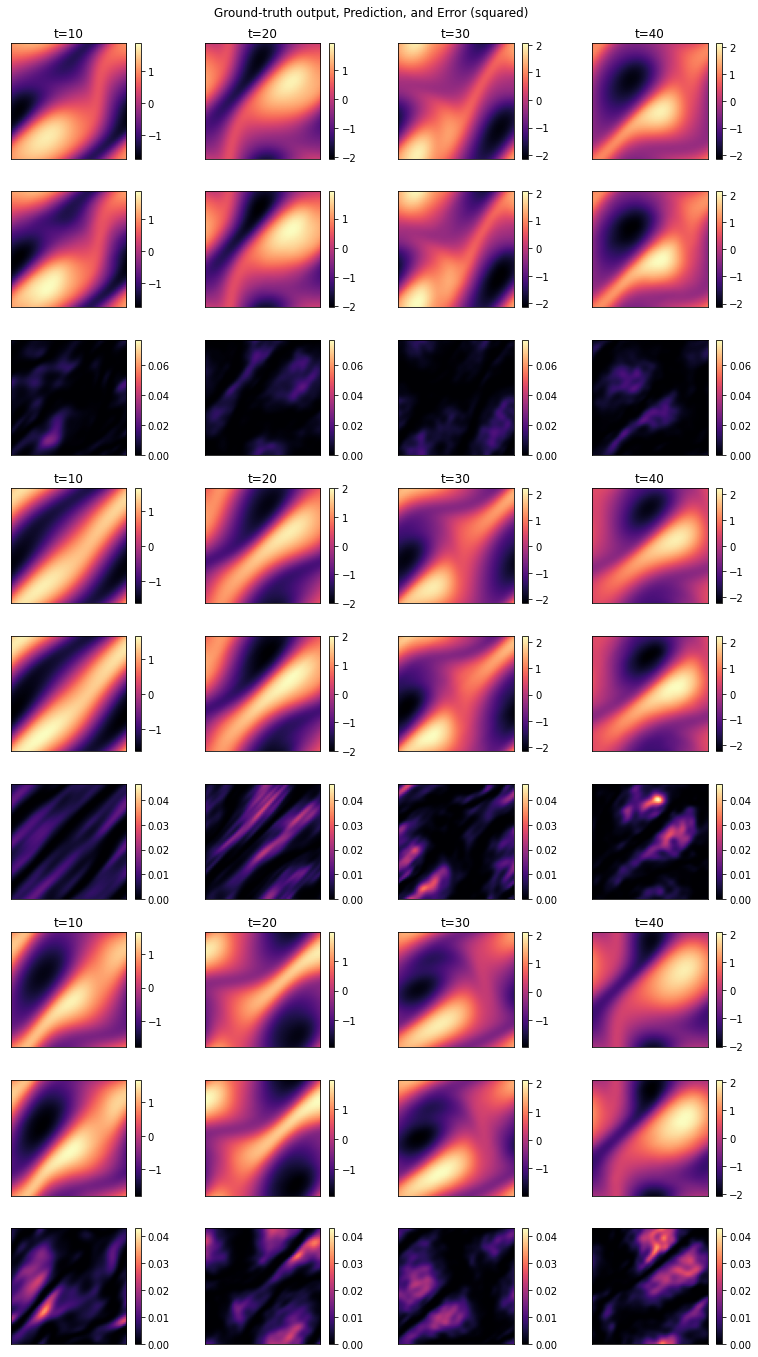

In [21]:
# test_samples = test_loader.dataset
n_samples = 3
n_rows = 3
n_cols = 4
t_step = 10

def sample_largest_error(error: torch.Tensor) -> int:
    m = [error[i].max() for i in range(error.shape[0])]
    mi = max(enumerate(m), key=lambda x: x[1])
    return mi[0]

fig = plt.figure(figsize=(11,  # width (inches)
                          19))  # height (inches)
for sample in range(n_samples):
    batch_number = 10 + 2 * sample
    _, yy, pred, error = sample_test_data(
        test_loader, batch_number, sample_largest_error)
    vmin = [
        min(yy[i].min(), pred[i].min())
        for i in range(9, 40, t_step)
    ] 
    vmax = [
        max(yy[i].max(), pred[i].max())
        for i in range(9, 40, t_step)
    ] 

    # Ground truth:
    r = sample * n_rows
    for c in range(n_cols):
        t = (c + 1) * t_step - 1
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(yy[t].cpu(),
                       cmap='magma', 
                       vmin=vmin[c], 
                       vmax=vmax[c])
        ax.set_title(f't={t + 1}')
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

    # Model prediction:
    r = sample * n_rows + 1
    for c in range(n_cols):
        t = (c + 1) * t_step - 1
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(pred[t].detach().cpu(),
                       cmap='magma', 
                       vmin=vmin[c], 
                       vmax=vmax[c])
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

    # Error:
    r = sample * n_rows + 2
    for c in range(n_cols):
        t = (c + 1) * t_step - 1   
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(error[t].detach().cpu(),
                       cmap='magma',
                       vmin=error.min(),
                       vmax=error.max())
        # print(f'{error[t].min():7.5f} <= error[t] <= {error[t].max():7.5f}')
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

fig.suptitle('Ground-truth output, Prediction, and Error (squared)', y=0.99)
plt.tight_layout()
fig.show()